## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA 


SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

## Setup 

In [1]:
import sys
sys.path.append('..')

In [2]:
# # Check the GPU
# !nvidia-smi

In [3]:
# !pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [4]:
# !pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [5]:
# !wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

## Dataset

In [6]:
# import os
# from google.colab import files

# pick a name for the image folder
local_dir = "../Messi/" #@param
# os.makedirs(local_dir)
# os.chdir(local_dir)

# # choose and upload local images into the newly created directory
# uploaded_images = files.upload()
# os.chdir("/content") # back to parent directory

#### Preview the images:

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

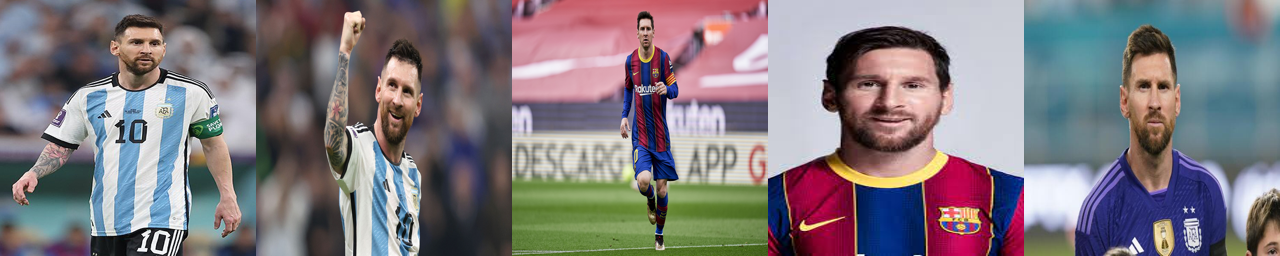

In [9]:
import glob

# change path to display images from your local dir
img_paths = "../Messi/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption images:

In [10]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

2024-09-16 14:53:42.679805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 14:53:43.403154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Loading the BLIP processor and captioning model

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

In [41]:
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [42]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "../Messi/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

### Adding token identifier

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.

We can add additional identifiers to the prefix that can help steer the model in the right direction.

In [43]:
import json

caption_prefix = "a photo of TOK messi, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      print(caption)
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

print(f"File jsonl file created at .{local_dir}metadata.jsonl")

a photo of TOK messi, lionel torres of argentina
a photo of TOK messi, a man with a tattoo on his arm
a photo of TOK messi, a man running on a soccer field
a photo of TOK messi, a man in a soccer uniform
a photo of TOK messi, a man with a beard and a beard on his head stands next to a young boy
File jsonl file created at .../Messi/metadata.jsonl


Adding prefix provides a sense of uniformity and helps in standardization during training

Freeing some memory:

In [16]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training

Initialize `accelerate`: Used to speed the training process for models with large number of parameters

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /home/khanhnq/.cache/huggingface/accelerate/default_config.yaml


### Log into Hugging Face account

In [18]:
from huggingface_hub import notebook_login
notebook_login()

## Training process

#### Set Hyperparameters 
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [19]:
# !pip install datasets -q

 - `--output_dir` : Specify LoRA model repository name!
 - `--caption_column` : Specify name of the caption column in the dataset. In this example we used "prompt" to save our captions in the metadata file

In [45]:
#!/usr/bin/env bash
!accelerate launch ../train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="../Messi" \
  --output_dir="messi_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK messi" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=5 \
  --checkpointing_steps=717 \
  --seed="0"

/home/khanhnq/anaconda3/envs/GAI/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/khanhnq/anaconda3/envs/GAI/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2024-09-16 15:08:40.399996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 15:08:40.420795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU in

### Saving the model to repo in HuggingFace

In [46]:
from huggingface_hub import whoami
from pathlib import Path
output_dir = "messi_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [48]:
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of TOK messi",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora=False,
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

events.out.tfevents.1726474135.pail.639315.0:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

events.out.tfevents.1726474135.pail.639315.1:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

events.out.tfevents.1726474096.pail.639079.0:   0%|          | 0.00/736 [00:00<?, ?B/s]

events.out.tfevents.1726474096.pail.639079.1:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Nyanmaru/messi_LoRA/commit/cb09d62bc61ed13110e054bb4bf1f4c4fb2642dd', commit_message='End of training', commit_description='', oid='cb09d62bc61ed13110e054bb4bf1f4c4fb2642dd', pr_url=None, pr_revision=None, pr_num=None)

In [49]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/Nyanmaru/messi_LoRA

Let's generate some images with it!

## Inference

In [50]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

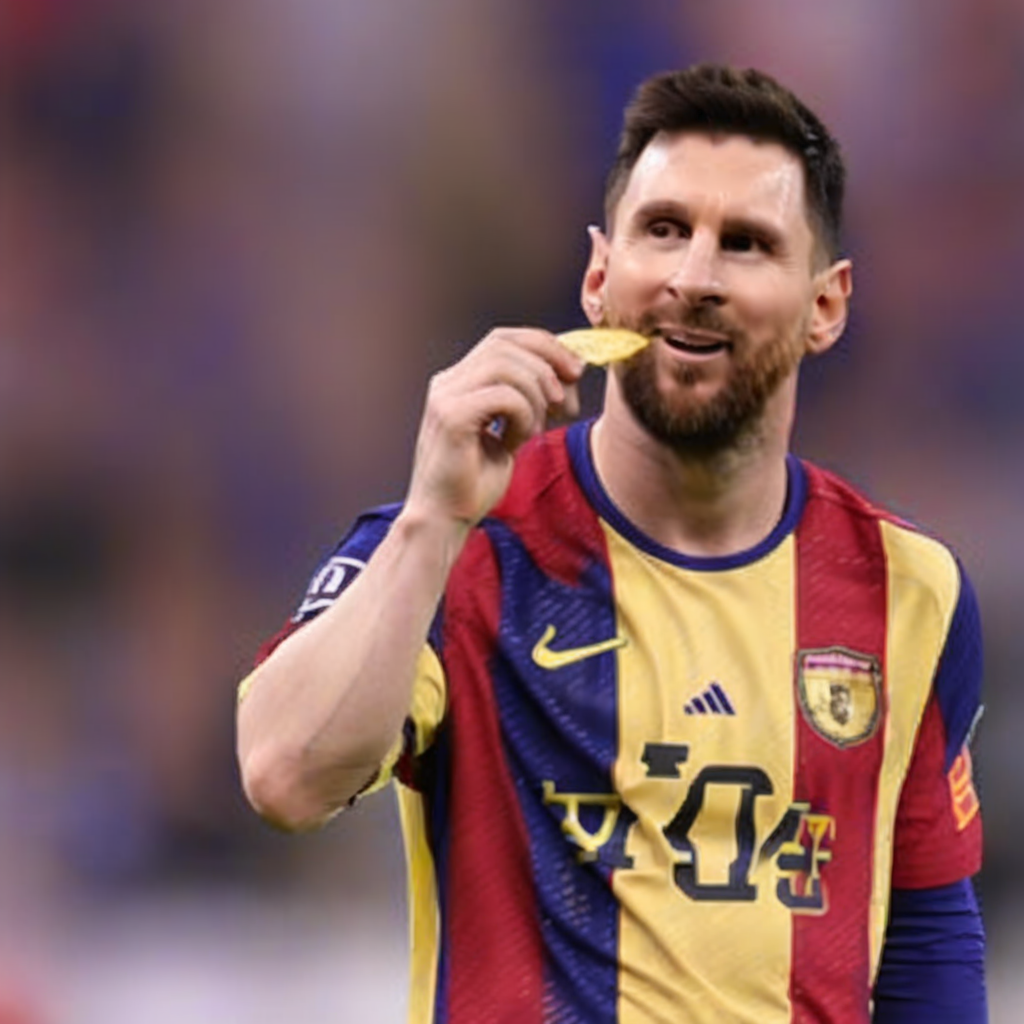

In [ ]:
prompt = "a photo of TOK messi eating crisps" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image